**1. Data Loading, Preparation, and Exploratory Data Analysis**

**1.1 Import Necessary Libraries**

In [73]:
# 1.1 Import Necessary Libraries

import os, zipfile, gc, re, json, warnings
import numpy as np
import pandas as pd

from google.colab import drive
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA

import joblib  # optional if you plan to save artifacts later

# Global settings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")

**1.2 Mount Google Drive**

In [74]:
# Mounts Google Drive to the Colab environment to access files.

drive.mount('/content/drive')

print("\n✅ Google Drive is successfully mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Google Drive is successfully mounted!


**1.3 Define, Unzip, and Load the Dataset**

In [75]:
# Description: Defines paths, extracts the zipped dataset, and loads all CSVs into a single DataFrame.

# Define paths and create directory
zip_path = '/content/drive/MyDrive/Tanvir/Dataset/MachineLearningCSV.zip'
extract_path = '/content/extracted_csvs/'
os.makedirs(extract_path, exist_ok=True)

# Unzip the dataset
print(f"--- Unzipping Dataset ---")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Dynamically find the name of the extracted folder
    extracted_items = os.listdir(extract_path)
    if not extracted_items:
        raise Exception("Extraction failed: The extraction directory is empty.")

    data_folder_name = extracted_items[0]
    data_folder_path = os.path.join(extract_path, data_folder_name)
    print(f"✅ Extraction complete. Data is in: '{data_folder_path}'")

    # Load and concatenate all CSV files
    print("\n--- Loading All Raw CSV Files ---")

    # Find all files in the directory that end with .csv
    csv_files = [f for f in os.listdir(data_folder_path) if f.endswith('.csv')]

    if not csv_files:
        raise Exception("No CSV files found in the extracted directory.")

    # Create a list to hold each loaded DataFrame
    df_list = []
    for file in sorted(csv_files): # sorted() ensures a consistent order
        print(f"-> Reading {file}...")
        file_path = os.path.join(data_folder_path, file)
        try:
            # on_bad_lines can help skip problematic rows
            df_temp = pd.read_csv(file_path, encoding='latin1', on_bad_lines='skip')
            df_list.append(df_temp)
        except Exception as e:
            print(f"  [WARNING] Could not read {file}: {e}")

    # Combine all DataFrames in the list into one
    if df_list:
        df = pd.concat(df_list, ignore_index=True)
        print(f"\n✅ All {len(df_list)} CSV files loaded and combined successfully.")
    else:
        print("\n❌ No data was loaded.")

except FileNotFoundError:
    print(f"\n❌ ERROR: Zip file not found at the specified path: {zip_path}")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

--- Unzipping Dataset ---
✅ Extraction complete. Data is in: '/content/extracted_csvs/MachineLearningCVE'

--- Loading All Raw CSV Files ---
-> Reading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
-> Reading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
-> Reading Friday-WorkingHours-Morning.pcap_ISCX.csv...
-> Reading Monday-WorkingHours.pcap_ISCX.csv...
-> Reading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
-> Reading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
-> Reading Tuesday-WorkingHours.pcap_ISCX.csv...
-> Reading Wednesday-workingHours.pcap_ISCX.csv...

✅ All 8 CSV files loaded and combined successfully.


**1.4 Initial Data Inspection**

In [76]:
# check if the dataframe exists before proceeding
if 'df' in locals():
    print("--- Starting Initial Data Inspection ---")

    # inspect basic information: shape and a sample of rows
    print(f"\n[INFO] Dataset Shape: {df.shape}")
    print("\n[INFO] First 5 Rows of the Dataset:")
    display(df.head())

    # check data types and look for non-null counts
    print("\n[INFO] Data Types and Non-Null Counts:")
    # using verbose=True ensures all columns are displayed
    df.info(verbose=True)

    # identify columns with problematic leading/trailing whitespace
    problematic_columns = [col for col in df.columns if col != col.strip()]
    if problematic_columns:
        print(f"\n[WARNING] Found {len(problematic_columns)} columns with leading/trailing whitespace in their names.")
        # print(f"Columns: {problematic_columns}")

    # check for the presence of infinite values, which can cause errors
    inf_counts = df.isin([np.inf, -np.inf]).sum()
    if inf_counts.sum() > 0:
        print("\n[WARNING] Found infinite values in the following columns:")
        print(inf_counts[inf_counts > 0])
    else:
        print("\n[INFO] No infinite values found in the dataset.")

    # inspect the raw distribution of the target variable, 'Label'
    # note the leading space in ' Label', which is common in this dataset
    if ' Label' in df.columns:
        print("\n[INFO] Raw Distribution of the 'Label' Column:")
        print(df[' Label'].value_counts())
    else:
        print("\n[WARNING] ' Label' column not found. Please check column names.")

else:
    print("❌ DataFrame 'df' not found. Please ensure the data loading cell (1.3) was executed successfully.")

--- Starting Initial Data Inspection ---

[INFO] Dataset Shape: (2830743, 79)

[INFO] First 5 Rows of the Dataset:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



[INFO] Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std            

**1.5 Initial Data Processing**

In [77]:
print("--- Initial Data Processing ---")

df_clean = df.copy()

# 1) Column cleanup
df_clean.columns = df_clean.columns.str.strip()
unnamed_cols = [c for c in df_clean.columns if str(c).lower().startswith('unnamed')]
if unnamed_cols:
    df_clean.drop(columns=unnamed_cols, inplace=True)

# 2) Replace inf -> NaN, coerce non-label columns to numeric, drop NaN rows
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
rows_before = len(df_clean)

# Find original label column (' Label' or 'Label'), keep a raw copy
label_col_guess = 'Label' if 'Label' in df_clean.columns else (' Label' if ' Label' in df_clean.columns else None)
assert label_col_guess is not None, "Label column not found ('Label' or ' Label')."

df_clean['LabelRaw'] = (
    df_clean[label_col_guess].astype(str)
    .str.replace('ï¿½', ' ', regex=False)  # encoding artifact
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

feature_cols = [c for c in df_clean.columns if c not in [label_col_guess, 'LabelRaw']]
for c in feature_cols:
    if not pd.api.types.is_numeric_dtype(df_clean[c]):
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

df_clean.dropna(inplace=True)
print(f"[INFO] Dropped {rows_before - len(df_clean)} rows with NaN/inf.")

# 3) Keep only BENIGN + Web Attack (using LabelRaw so we can canonicalize after)
is_benign = df_clean['LabelRaw'].str.upper() == 'BENIGN'
is_web_attack = df_clean['LabelRaw'].str.contains('Web Attack', case=False, regex=False)
df_clean = df_clean[is_benign | is_web_attack].copy()
print("[INFO] Kept BENIGN + Web Attack rows.")

# 4) Canonicalize into 'Label' (overwrite); keep LabelRaw for reference
CANON = {
    'BENIGN': 'BENIGN',
    'WEB ATTACK BRUTE FORCE': 'WEB_ATTACK_BRUTE_FORCE',
    'WEB ATTACK XSS': 'WEB_ATTACK_XSS',
    'WEB ATTACK SQL INJECTION': 'WEB_ATTACK_SQLI',
}
def normalize_label(lbl: str) -> str:
    lbl = lbl.replace('–', '-').replace('—', '-')
    lbl = lbl.replace('-', ' ')
    lbl = re.sub(r'\s+', ' ', lbl).strip().upper()
    return CANON.get(lbl, lbl)

df_clean['Label'] = df_clean['LabelRaw'].map(normalize_label)
df_clean = df_clean[df_clean['Label'].isin(CANON.values())].copy()

# 5) Remove invalid negatives in Flow Duration if present
if 'Flow Duration' in df_clean.columns:
    neg = (df_clean['Flow Duration'] < 0).sum()
    if neg > 0:
        df_clean = df_clean[df_clean['Flow Duration'] >= 0].copy()
        print(f"[INFO] Removed {neg} rows with negative 'Flow Duration'.")

# Optional convenience: binary label
df_clean['LabelBinary'] = np.where(df_clean['Label'] == 'BENIGN', 'BENIGN', 'WEB_ATTACK')

print(f"\n[INFO] Cleaned shape: {df_clean.shape}")
print("[INFO] Label distribution (canonical, in 'Label'):")
display(df_clean['Label'].value_counts())

--- Initial Data Processing (Canonicalize Label) ---
[INFO] Dropped 2867 rows with NaN/inf.
[INFO] Kept BENIGN + Web Attack rows.
[INFO] Removed 115 rows with negative 'Flow Duration'.

[INFO] Cleaned shape: (2273385, 81)
[INFO] Label distribution (canonical, in 'Label'):


,count
Label,
BENIGN,2271205
WEB_ATTACK_BRUTE_FORCE,1507
WEB_ATTACK_XSS,652
WEB_ATTACK_SQLI,21


**1.6 Exploratory Data Analysis (EDA)**

**1.6.1 Univariate Analysis**

--- Starting Exploratory Data Analysis ---


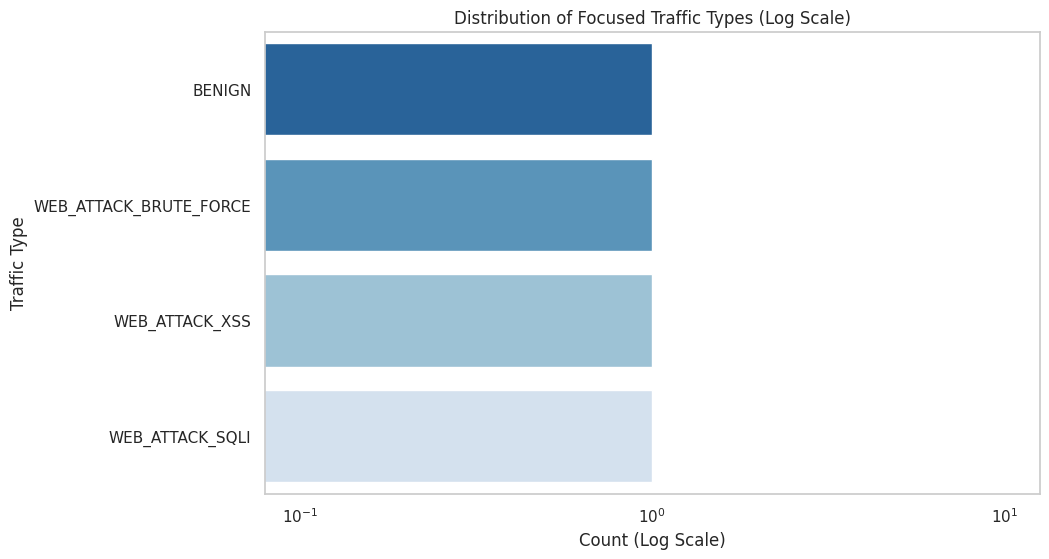


--- Histograms for a Selection of Numerical Features ---


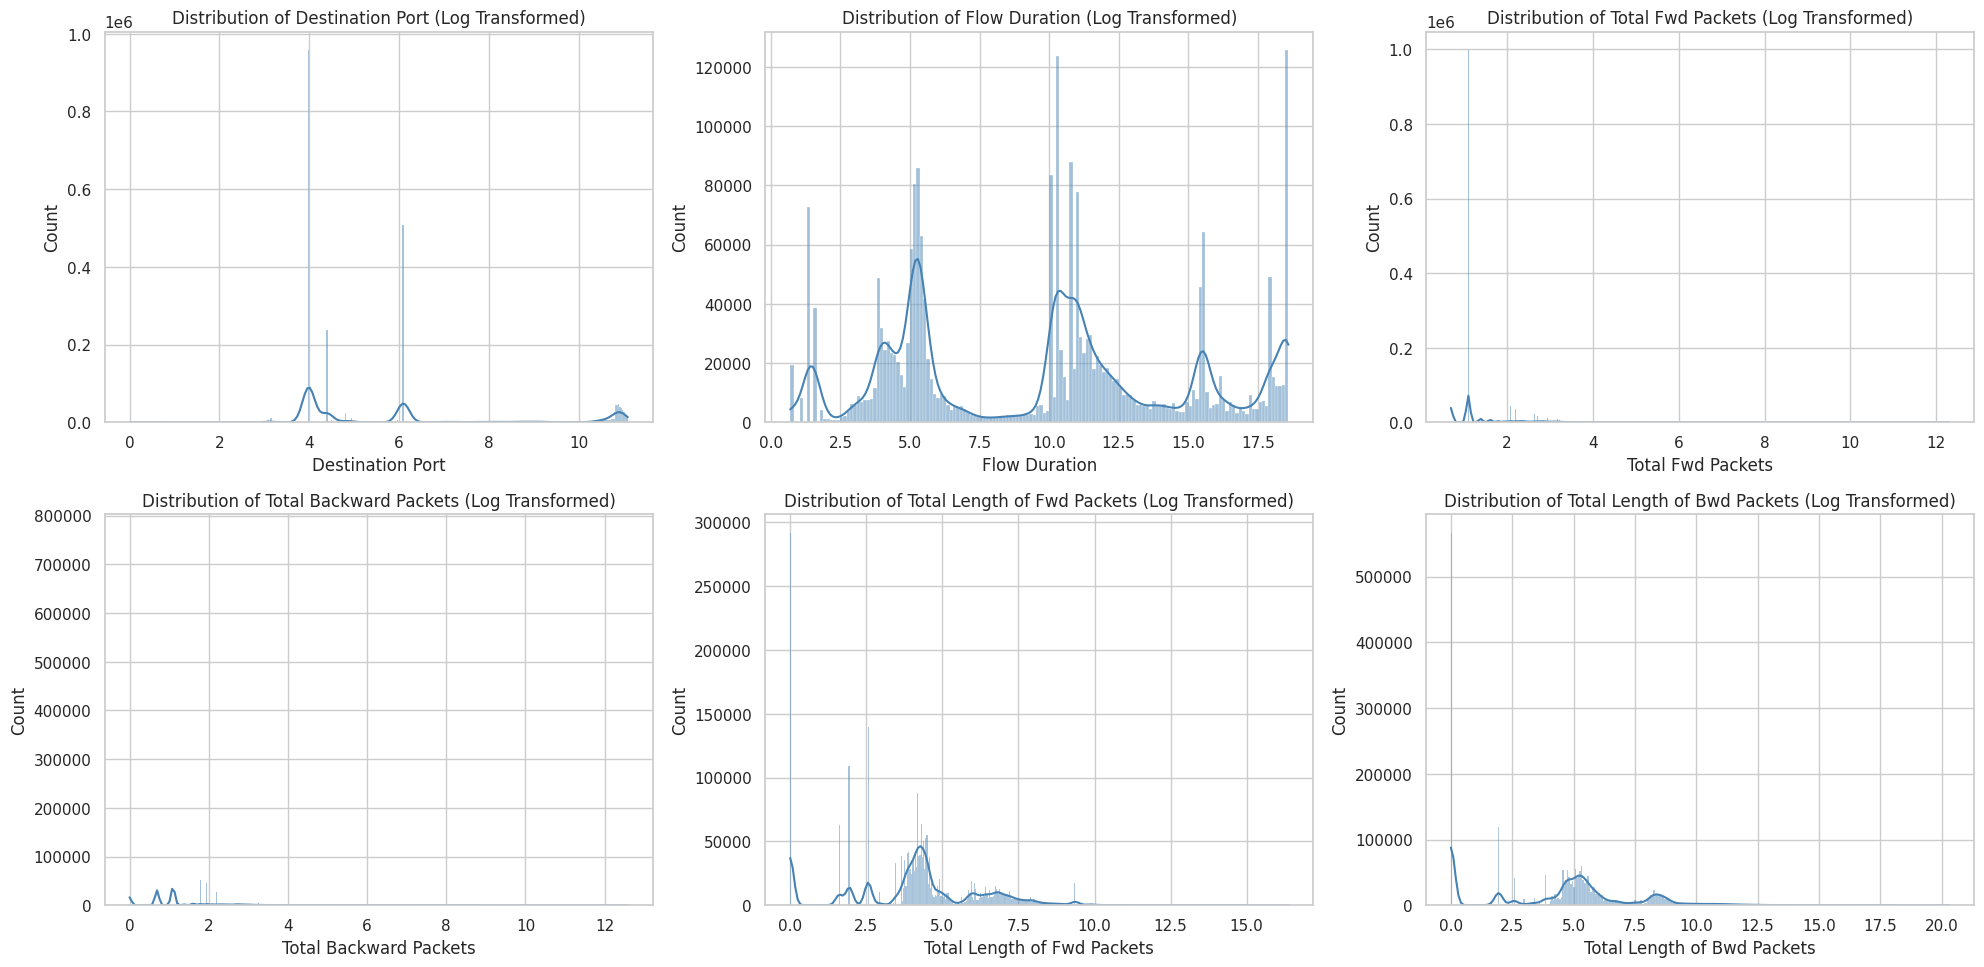


--- Skewness of Numerical Features ---
Top 10 most skewed features:
Total Length of Fwd Packets    812.266595
Subflow Fwd Bytes              810.477244
act_data_pkt_fwd               255.077706
Subflow Bwd Packets            219.289463
Total Backward Packets         219.289463
Total Fwd Packets              219.041887
Subflow Fwd Packets            219.041887
Subflow Bwd Bytes              218.976865
Total Length of Bwd Packets    218.972915
Fwd URG Flags                   84.935887
dtype: float64

--- Box Plots for Outlier Analysis ---


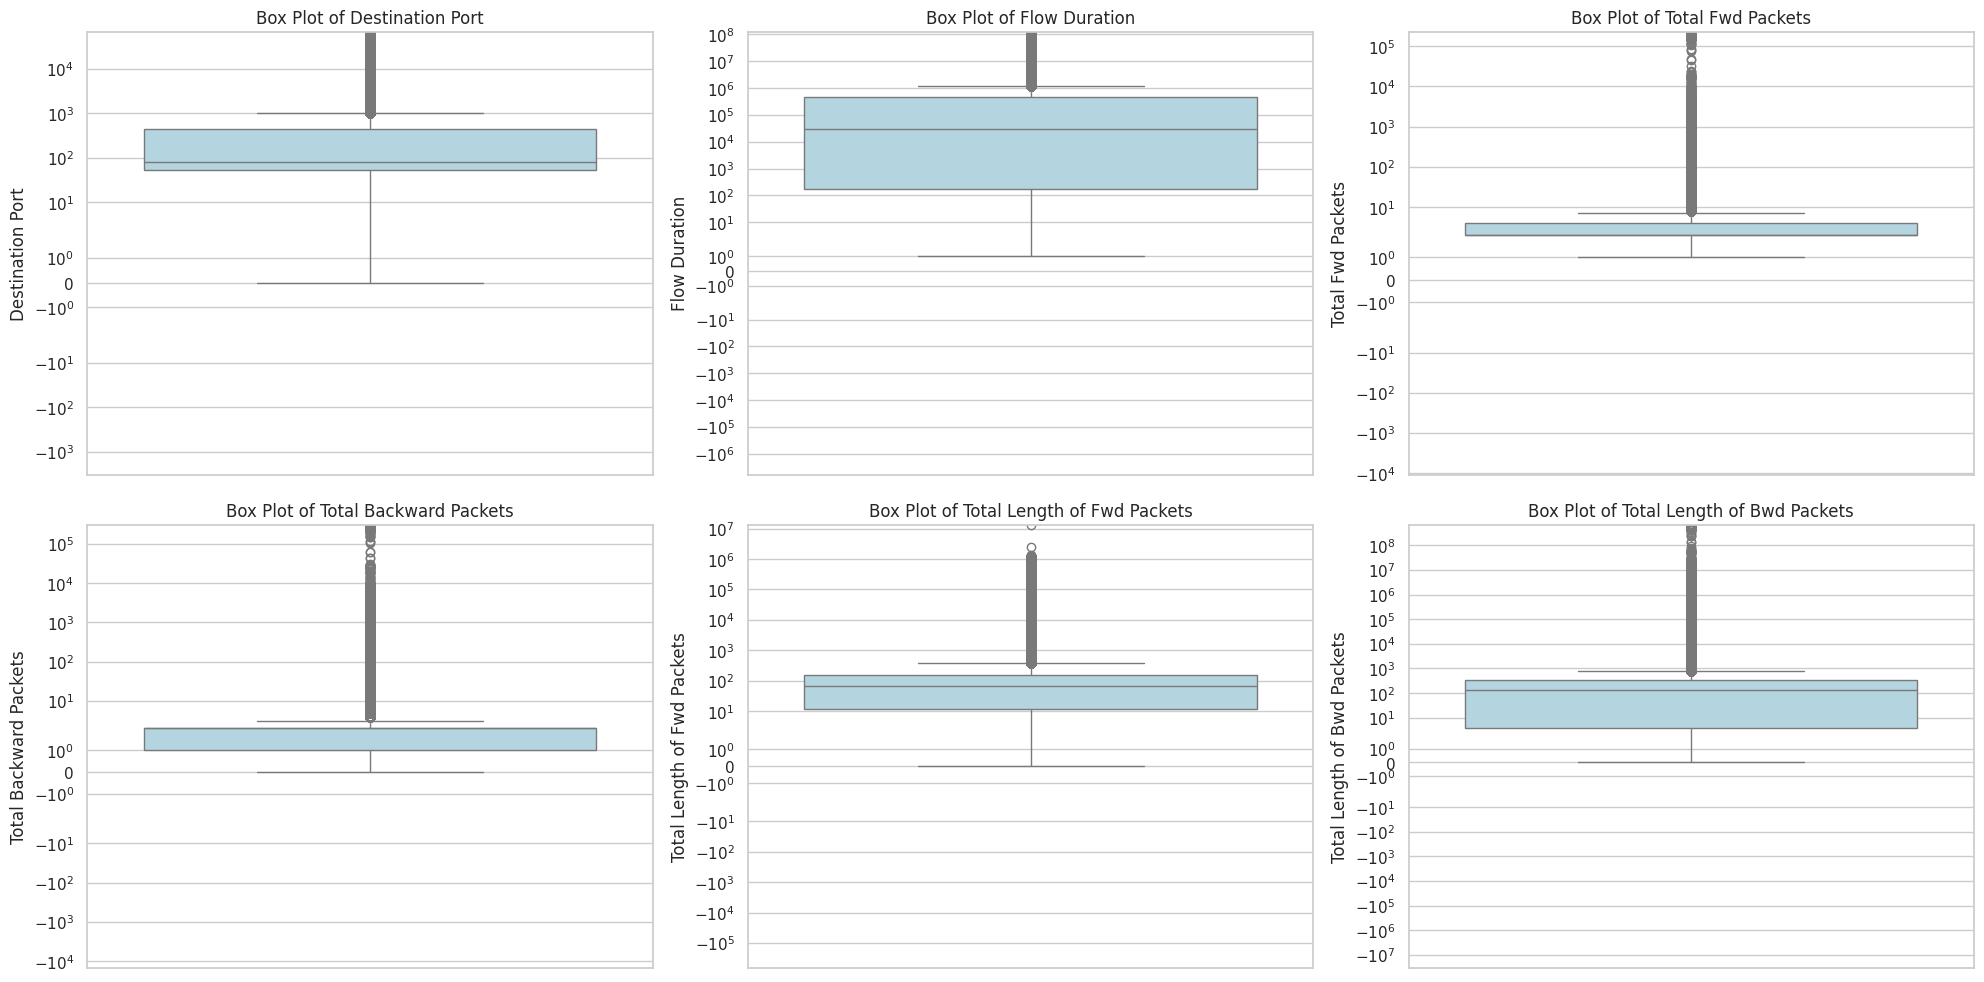


--- Statistical Summaries ---

[INFO] Numerical Features Summary:


,count,mean,std,min,25%,50%,75%,max
Destination Port,2273385.0,9.395646e+03,1.973583e+04,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2273385.0,1.122566e+07,3.012075e+07,1.0,175.0,31012.0,466226.0,119999998.0
Total Fwd Packets,2273385.0,1.066208e+01,8.364835e+02,1.0,2.0,2.0,4.0,219759.0
Total Backward Packets,2273385.0,1.214174e+01,1.112919e+03,0.0,1.0,2.0,2.0,291922.0
Total Length of Fwd Packets,2273385.0,6.371934e+02,1.063691e+04,0.0,12.0,66.0,160.0,12900000.0
...,...,...,...,...,...,...,...,...
Active Min,2273385.0,5.086722e+04,5.582985e+05,0.0,0.0,0.0,0.0,110000000.0
Idle Mean,2273385.0,3.745493e+06,1.349051e+07,0.0,0.0,0.0,0.0,120000000.0
Idle Std,2273385.0,2.603379e+05,2.974460e+06,0.0,0.0,0.0,0.0,76900000.0
Idle Max,2273385.0,3.937426e+06,1.411007e+07,0.0,0.0,0.0,0.0,120000000.0


In [78]:
### 1.6.1 Univariate Analysis (Comprehensive Version) ###

# check that the cleaned dataframe exists before proceeding
if 'df_clean' in locals():
    print("--- Starting Exploratory Data Analysis ---")

    # --- 1. Target Variable Analysis (Bar Plot) ---
    plt.figure(figsize=(10, 6))
    plt.xscale('log')
    sns.countplot(y='Label', data=df_clean, order=df_clean['Label'].value_counts().index, palette='Blues_r')
    plt.title('Distribution of Focused Traffic Types (Log Scale)')
    plt.xlabel('Count (Log Scale)')
    plt.ylabel('Traffic Type')
    plt.grid(axis='x')
    plt.show()

    # --- 2. Numerical Feature Distribution (Histograms) ---
    print("\n--- Histograms for a Selection of Numerical Features ---")
    numeric_cols = df_clean.select_dtypes(include=np.number).columns
    # Select a few key features to plot (e.g., the first 6)
    features_to_plot = numeric_cols[:6]

    # Create a grid of histograms
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten() # Flatten the 2x3 grid into a 1D array

    for i, feature in enumerate(features_to_plot):
        sns.histplot(np.log1p(df_clean[feature]), kde=True, ax=axes[i], color="steelblue")
        axes[i].set_title(f'Distribution of {feature} (Log Transformed)')

    plt.tight_layout()
    plt.show()

    # --- 3. Quantitative Skewness Analysis ---
    print("\n--- Skewness of Numerical Features ---")
    skewness = df_clean[numeric_cols].skew().sort_values(ascending=False)
    print("Top 10 most skewed features:")
    print(skewness.head(10))

    # --- 4. Outlier Analysis (Box Plots) ---
    print("\n--- Box Plots for Outlier Analysis ---")
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features_to_plot):
        sns.boxplot(y=df_clean[feature], ax=axes[i], color='lightblue')
        axes[i].set_yscale('symlog') # Use 'symlog' to handle zeros and see outliers
        axes[i].set_title(f'Box Plot of {feature}')

    plt.tight_layout()
    plt.show()

    # --- 5. Statistical Summaries (Unchanged) ---
    print("\n--- Statistical Summaries ---")
    print("\n[INFO] Numerical Features Summary:")
    display(df_clean.describe().T)

else:
    print("❌ DataFrame 'df_clean' not found. Please ensure previous cells were executed successfully.")

**1.6.2 Bivariate Analysis**

--- Bivariate Analysis: Best Visualizations ---


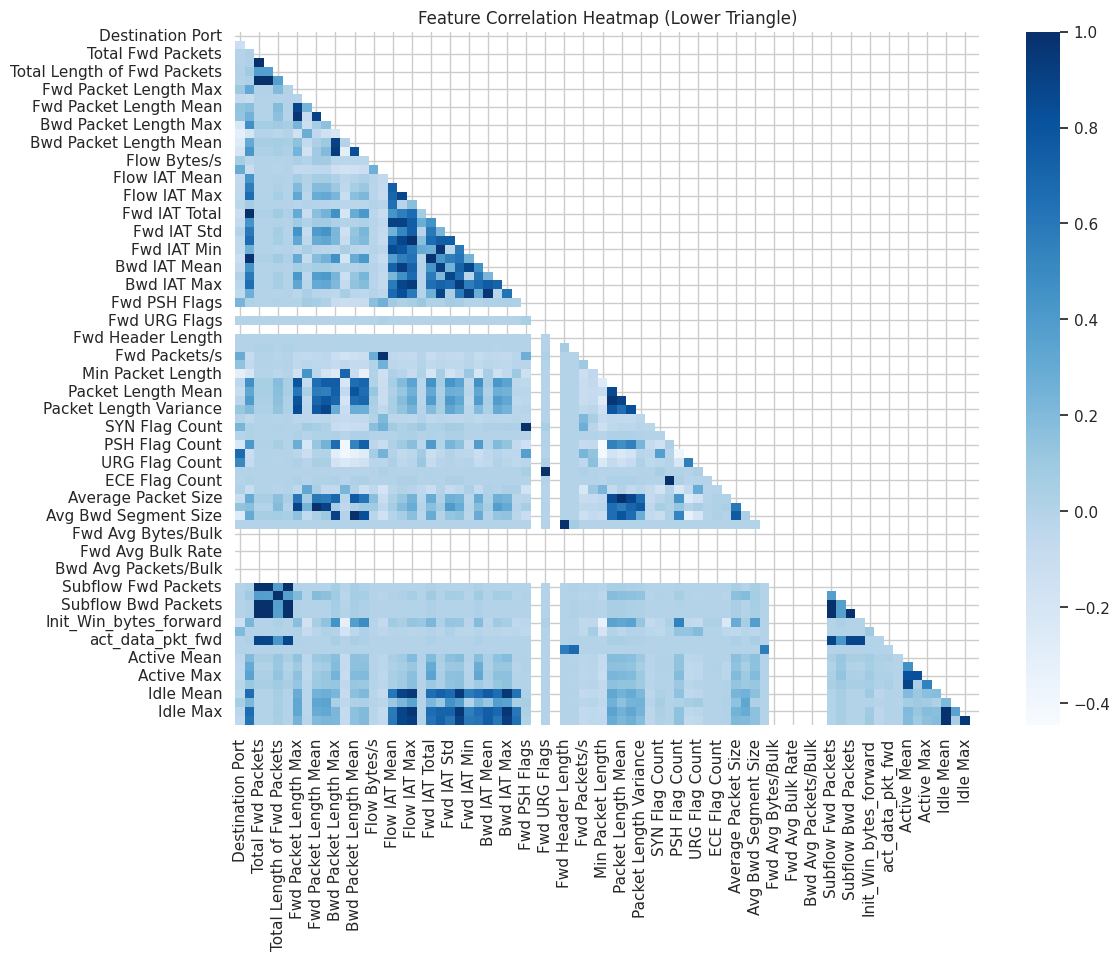


--- Violin Plots for Key Features vs. Traffic Type ---


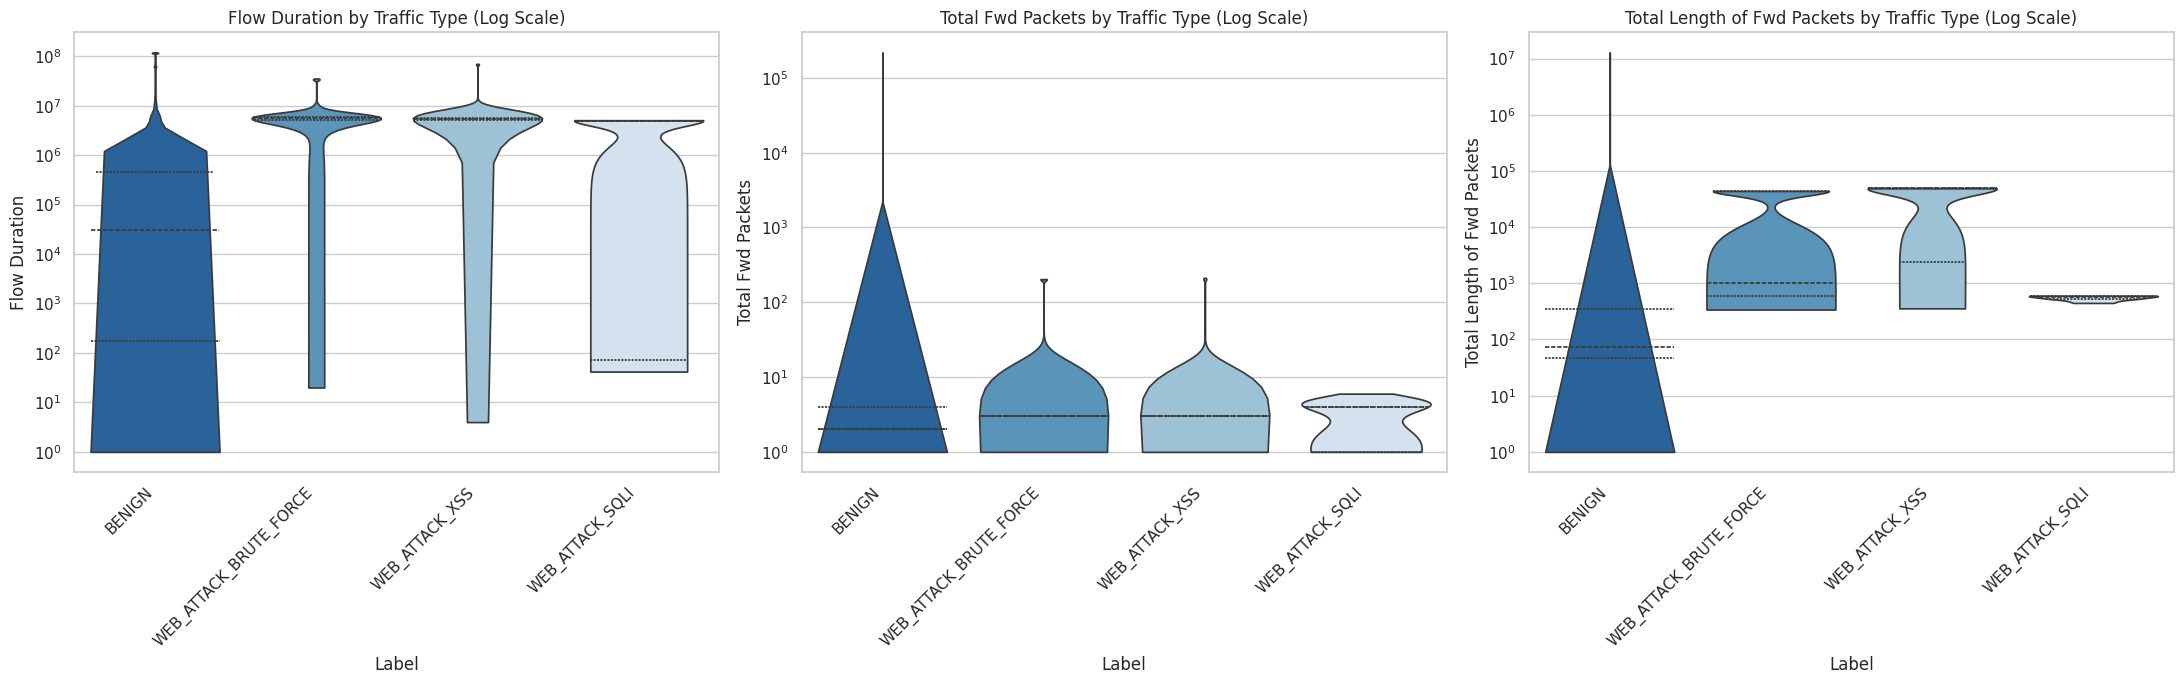


--- (Template) Normalized Categorical vs. Categorical Analysis ---


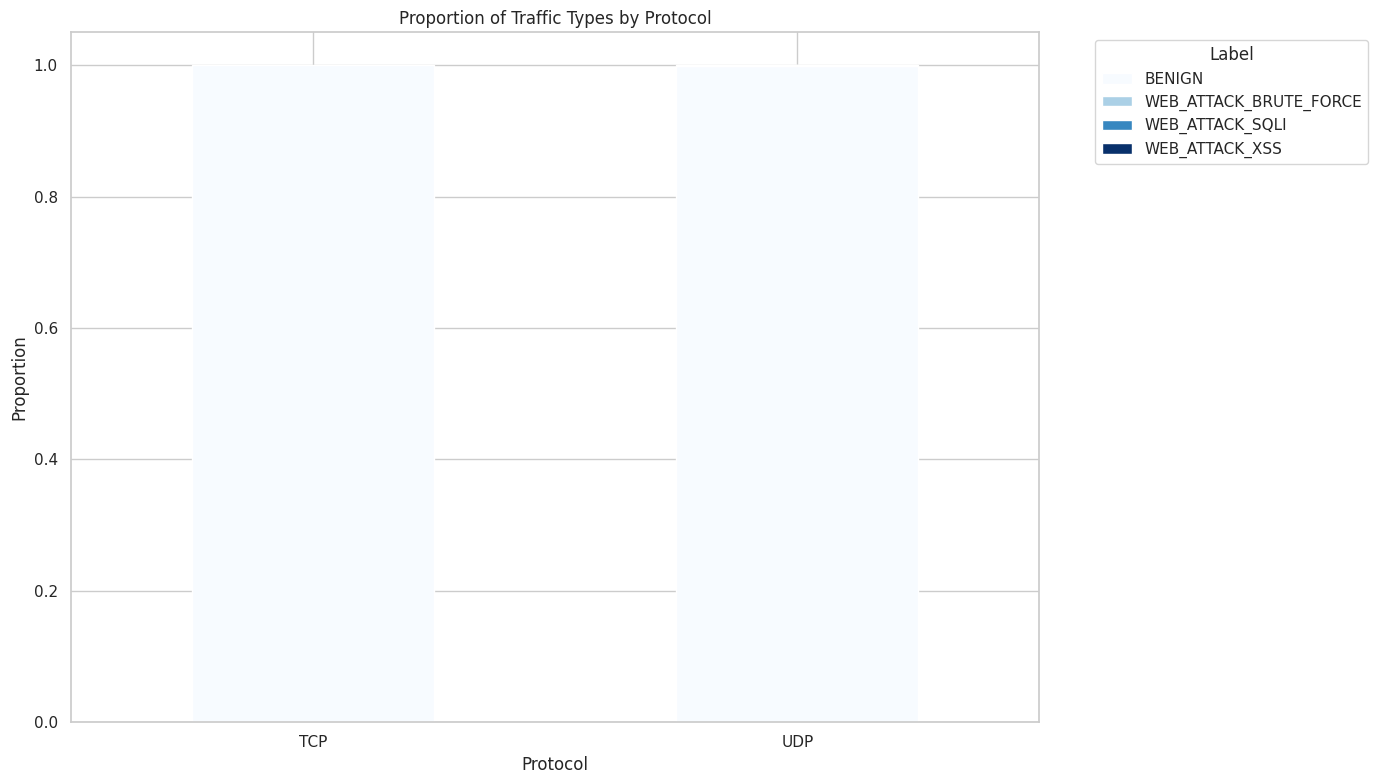

In [79]:
# check that the cleaned dataframe exists before proceeding
if 'df_clean' in locals():
    print("--- Bivariate Analysis: Best Visualizations ---")

    # --- 1. Numeric vs. Numeric: Enhanced Correlation Heatmap ---
    # We'll mask the upper triangle to remove redundancy and improve clarity.
    plt.figure(figsize=(12, 9))
    numeric_df = df_clean.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, cmap='Blues', mask=mask)
    plt.title('Feature Correlation Heatmap (Lower Triangle)')
    plt.show()

    # --- 2. Numeric vs. Categorical: Grid of Violin Plots ---
    # Analyze multiple key features to get a broader understanding.
    features_to_plot = ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets']
    print("\n--- Violin Plots for Key Features vs. Traffic Type ---")

    fig, axes = plt.subplots(1, 3, figsize=(22, 7))

    for i, feature in enumerate(features_to_plot):
        # Filter out zero values for each feature for proper log scaling
        df_positive = df_clean[df_clean[feature] > 0]

        sns.violinplot(x='Label', y=feature, data=df_positive,
                       palette='Blues_r', inner='quartile', cut=0, ax=axes[i])
        axes[i].set_yscale('log')
        axes[i].set_title(f'{feature} by Traffic Type (Log Scale)')
        # Rotate x-axis labels for readability
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # --- 3. Categorical vs. Categorical: Normalized Stacked Bar Chart ---
    print("\n--- (Template) Normalized Categorical vs. Categorical Analysis ---")
    # Create hypothetical 'Protocol' column if it doesn't exist
    if 'Protocol' not in df_clean.columns:
        df_clean['Protocol'] = df_clean['Destination Port'].apply(lambda p: 'TCP' if p > 1024 else 'UDP')

    # Create a contingency table and normalize it to show percentages
    contingency_table = pd.crosstab(df_clean['Protocol'], df_clean['Label'])
    normalized_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)

    # Plot the 100% stacked bar chart
    normalized_table.plot(kind='bar', stacked=True, figsize=(14, 8),
                          colormap='Blues', title='Proportion of Traffic Types by Protocol')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("❌ DataFrame 'df_clean' not found. Please ensure previous cells were executed successfully.")

**1.6.3 Multivariate Analysis**

--- Multivariate Analysis ---

--- Pairplot with Improved Clarity ---


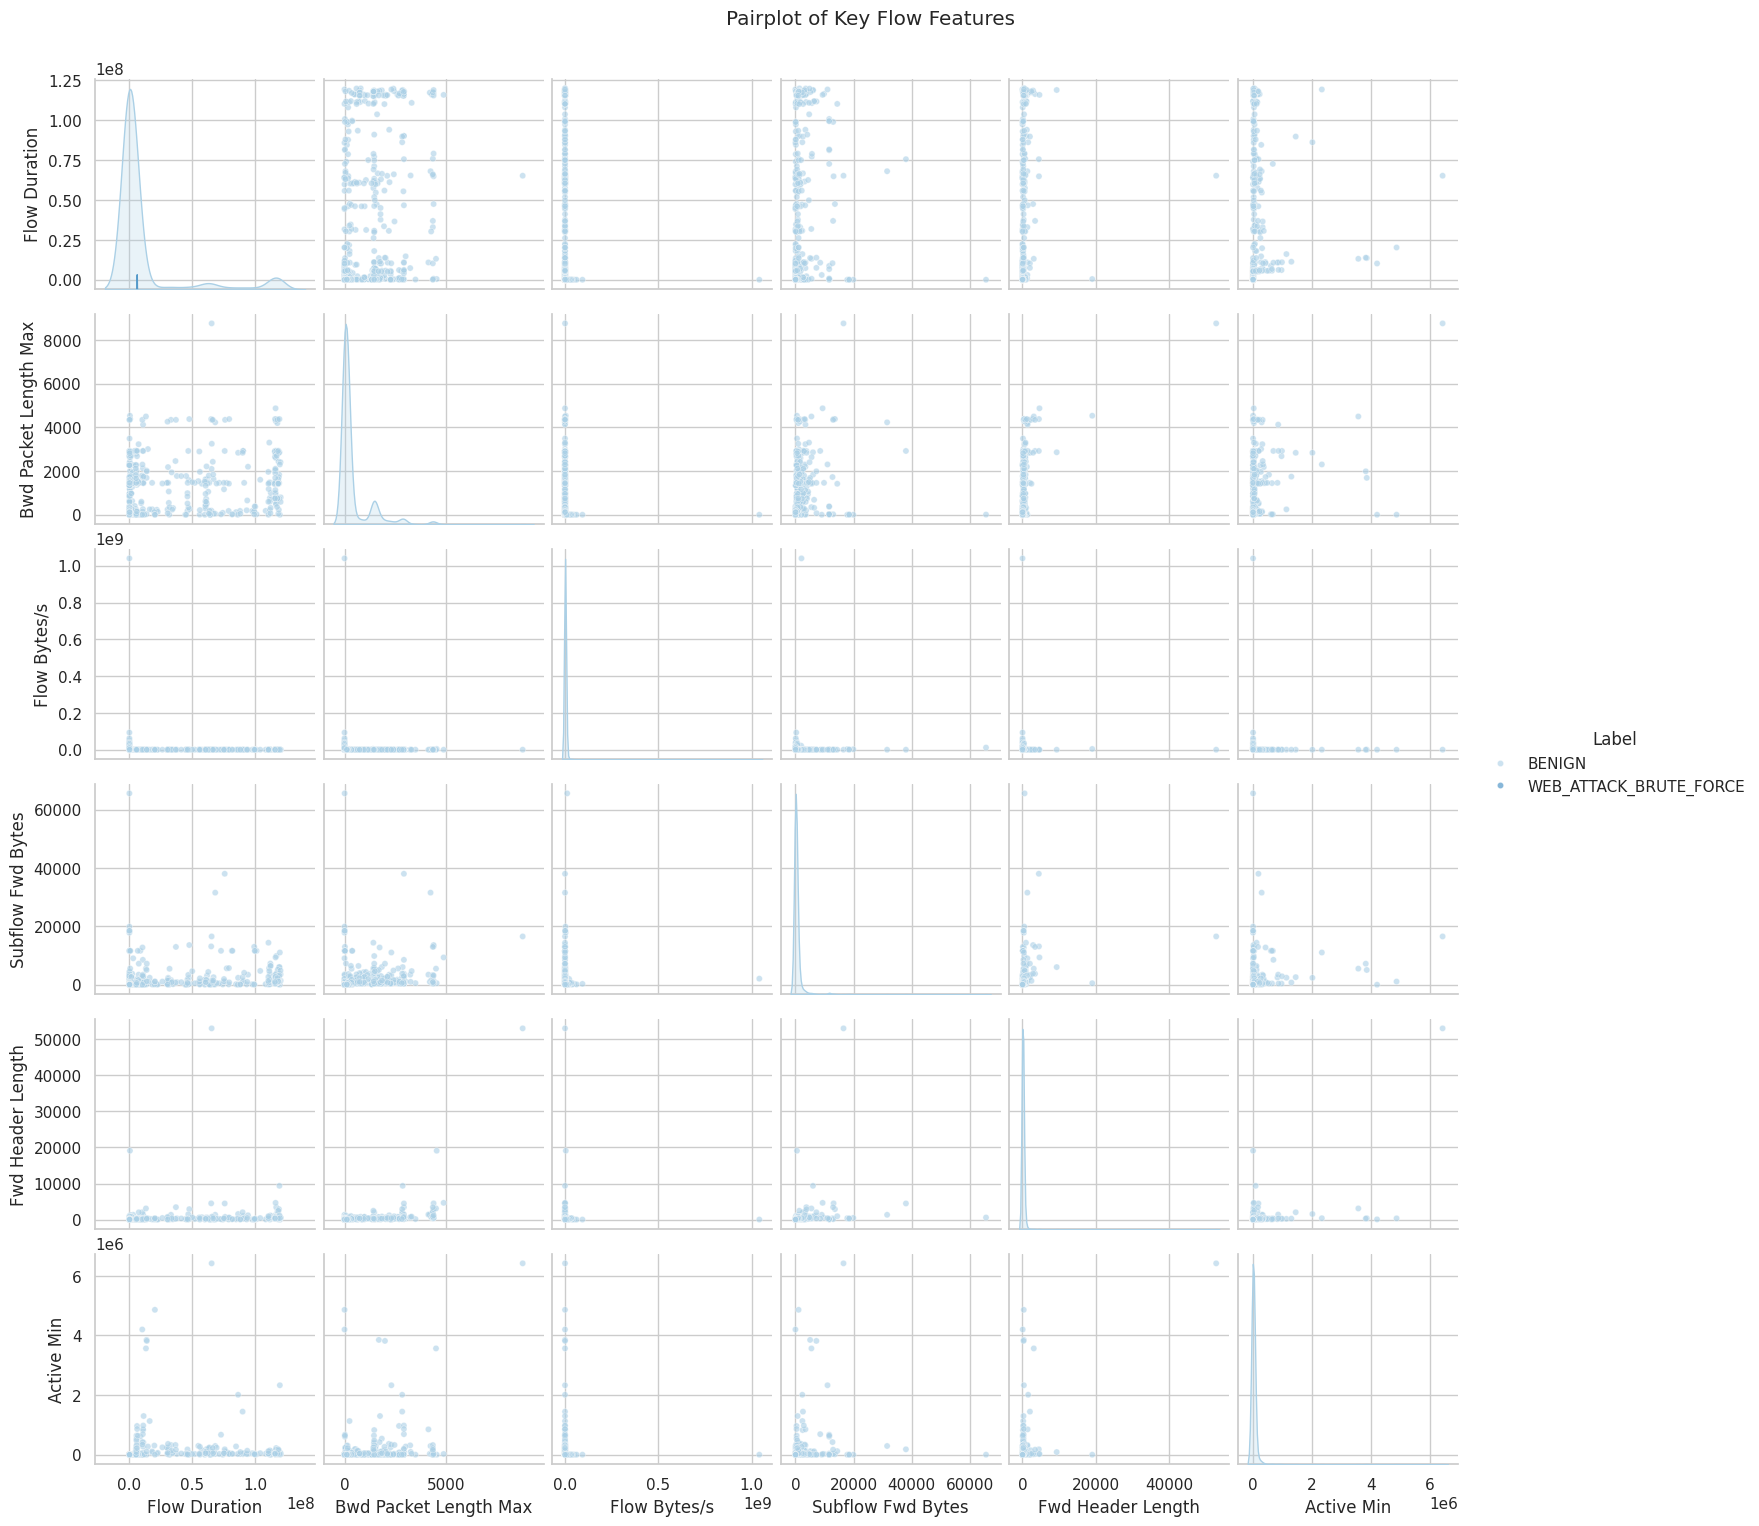


--- Principal Component Analysis (PCA) ---


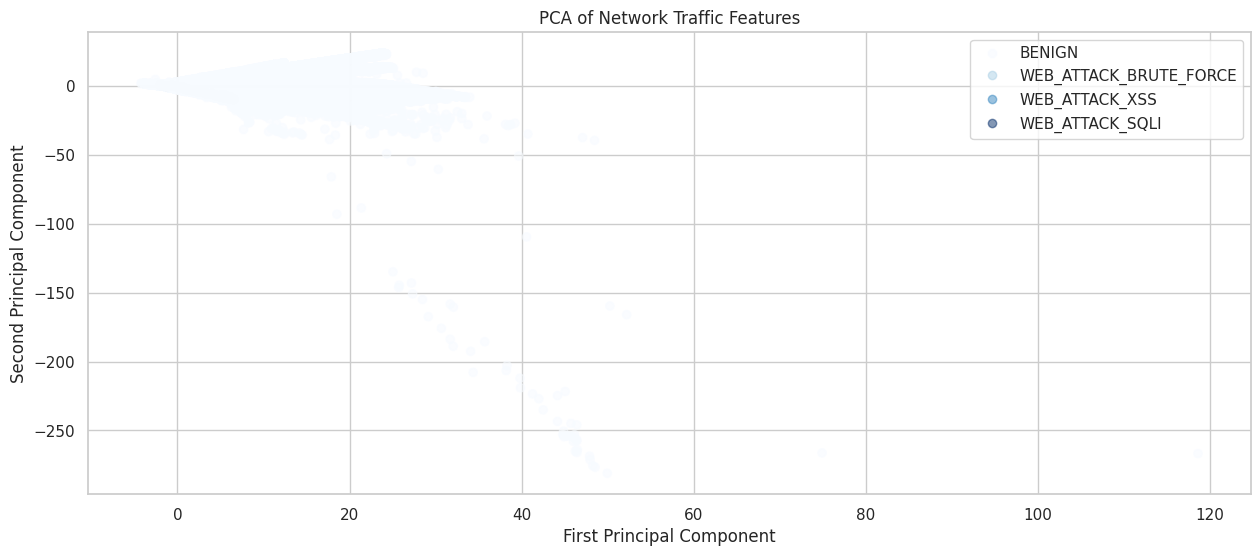


--- PCA Component Loadings ---


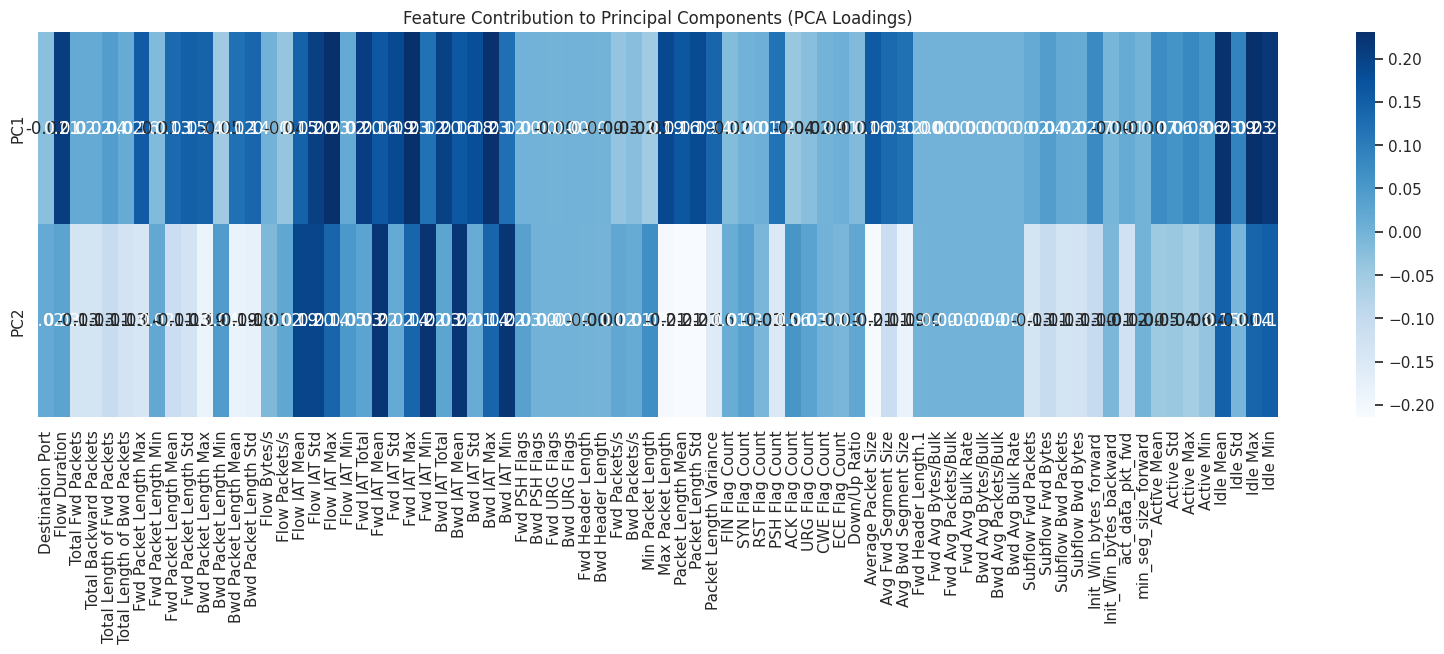


--- t-SNE Visualization on a Data Sample ---


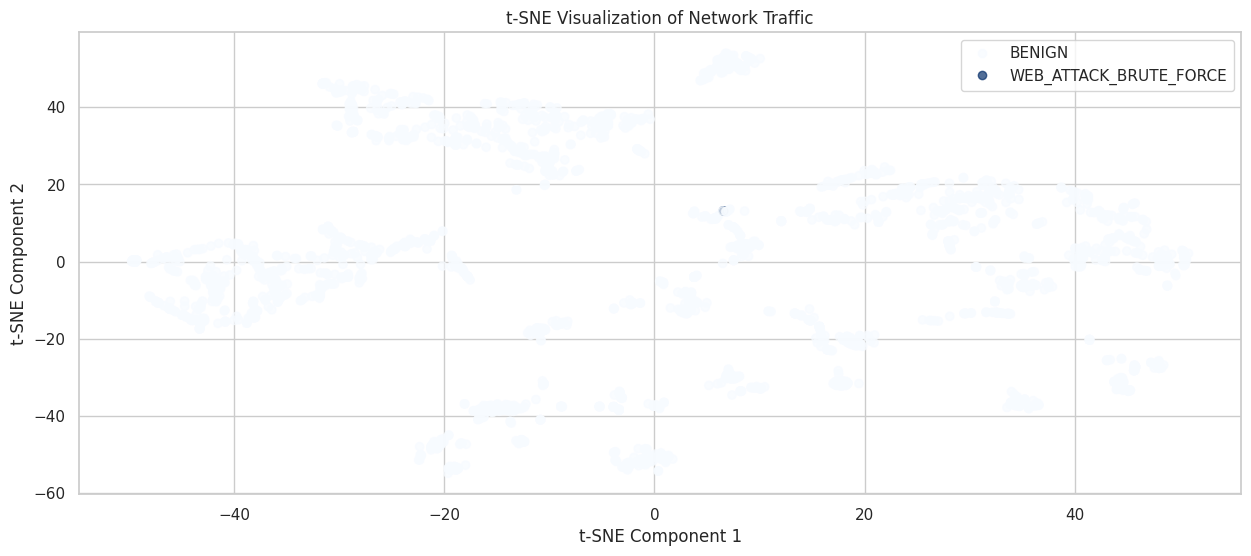

In [80]:
### 1.6.3 Multivariate Analysis (Enhanced Version) ###

if 'df_clean' in locals():
    print("--- Multivariate Analysis ---")

    # Prepare a sample of the data for performance-intensive plots (t-SNE, Pairplot)
    sample_df = df_clean.sample(n=2000, random_state=42)
    numeric_sample = sample_df.select_dtypes(include=[np.number])
    label_sample = sample_df['Label']

    # --- 1. Refined Pairplot of Key Features ---
    print("\n--- Pairplot with Improved Clarity ---")
    key_features = ['Flow Duration', 'Bwd Packet Length Max', 'Flow Bytes/s',
                    'Subflow Fwd Bytes', 'Fwd Header Length', 'Active Min']
    available_features = [f for f in key_features if f in df_clean.columns]

    # Define a specific order for the labels to ensure BENIGN is first
    label_order = sorted(sample_df['Label'].unique(), key=lambda x: (x != 'BENIGN', x))

    # Use the standard 'Blues' palette so the first item ('BENIGN') is the lightest
    sns.pairplot(sample_df, hue='Label', vars=available_features, palette='Blues',
                 hue_order=label_order, # Enforce the label order
                 plot_kws={'alpha': 0.6, 's': 20})
    plt.suptitle('Pairplot of Key Flow Features', y=1.02)
    plt.show()

    # --- 2. PCA with Interpretation ---
    print("\n--- Principal Component Analysis (PCA) ---")
    # This section is already correct. 'pd.factorize' assigns 0 to 'BENIGN' (the first label it sees),
    # and cmap='Blues' maps low values (0) to light colors and higher values to darker colors.
    numeric_df = df_clean.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(numeric_df)
    y = df_clean['Label']

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(15, 6))
    label_codes, unique_labels = pd.factorize(y)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label_codes, cmap='Blues', alpha=0.5)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA of Network Traffic Features')
    plt.legend(handles=scatter.legend_elements()[0], labels=unique_labels.tolist())
    plt.show()

    # ... (PCA Loadings heatmap code remains the same) ...
    print("\n--- PCA Component Loadings ---")
    plt.figure(figsize=(20, 5))
    components = pd.DataFrame(pca.components_, columns=numeric_df.columns, index=['PC1', 'PC2'])
    sns.heatmap(components, cmap='Blues', annot=True, fmt='.2f')
    plt.title('Feature Contribution to Principal Components (PCA Loadings)')
    plt.show()


    # --- 3. Advanced Cluster Visualization with t-SNE ---
    print("\n--- t-SNE Visualization on a Data Sample ---")
    # This section is also already correct for the same reason as PCA.
    from sklearn.manifold import TSNE

    X_sample_scaled = scaler.fit_transform(numeric_sample)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_sample_scaled)

    plt.figure(figsize=(15, 6))
    label_codes_sample, unique_labels_sample = pd.factorize(label_sample)
    scatter_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label_codes_sample, cmap='Blues', alpha=0.7)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Visualization of Network Traffic')
    plt.legend(handles=scatter_tsne.legend_elements()[0], labels=unique_labels_sample.tolist())
    plt.show()

else:
    print("❌ DataFrame 'df_clean' not found. Please ensure previous cells were executed successfully.")

**2. Data Processing**

**2.1 Define Features and Stratified 60/20/20 Split**

In [81]:
from sklearn.model_selection import train_test_split

# Exclude target/helper columns
non_feature_cols = {'Label', 'LabelBinary', 'LabelRaw'}
if 'Protocol' in df_clean.columns:  # EDA may have created it
    non_feature_cols.add('Protocol')

feature_cols = [c for c in df_clean.columns if c not in non_feature_cols]

# Numeric-only features + target
X = df_clean[feature_cols].copy()
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    X = X.drop(columns=obj_cols)

y = df_clean['Label'].copy()

# Check minimal per-class counts
vc = y.value_counts()
assert vc.min() >= 3, "Too few samples for a 3-way stratified split."

# 60/20/20 stratified split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE)
X_vlidation, X_test, y_vlidation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)
del X_temp, y_temp; gc.collect()

print(f"Shapes -> TRAIN: {X_train.shape}, VLIDATION: {X_vlidation.shape}, TEST: {X_test.shape}")

def summarize_split(name, y_ser):
    cnt = y_ser.value_counts()
    pct = (cnt / cnt.sum() * 100).round(3)
    print(f"\n{name}: n={len(y_ser)}")
    display(pd.DataFrame({'count': cnt, 'pct': pct}))

summarize_split("TOTAL", y)
summarize_split("TRAIN (60%)", y_train)
summarize_split("VLIDATION (20%)", y_vlidation)
summarize_split("TEST (20%)", y_test)

Shapes -> TRAIN: (1364031, 78), VLIDATION: (454677, 78), TEST: (454677, 78)

TOTAL: n=2273385


,count,pct
Label,,
BENIGN,2271205,99.904
WEB_ATTACK_BRUTE_FORCE,1507,0.066
WEB_ATTACK_XSS,652,0.029
WEB_ATTACK_SQLI,21,0.001



TRAIN (60%): n=1364031


,count,pct
Label,,
BENIGN,1362723,99.904
WEB_ATTACK_BRUTE_FORCE,904,0.066
WEB_ATTACK_XSS,391,0.029
WEB_ATTACK_SQLI,13,0.001



VLIDATION (20%): n=454677


,count,pct
Label,,
BENIGN,454241,99.904
WEB_ATTACK_BRUTE_FORCE,301,0.066
WEB_ATTACK_XSS,131,0.029
WEB_ATTACK_SQLI,4,0.001



TEST (20%): n=454677


,count,pct
Label,,
BENIGN,454241,99.904
WEB_ATTACK_BRUTE_FORCE,302,0.066
WEB_ATTACK_XSS,130,0.029
WEB_ATTACK_SQLI,4,0.001


**2.2 Leakage-Safe Feature Hygiene and Cross-Split De-Duplication**

In [82]:
# 2.3 Leakage-Safe Feature Hygiene and Cross-Split De-Duplication (Train-only)

import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object

# Toggles
PRUNE_HIGH_CORR = True        # set False to skip correlation-based pruning
HIGH_CORR_THRESHOLD = 0.995   # absolute correlation threshold for dropping
CORR_SAMPLE_N = 500_000       # sample size to estimate correlations (for speed)
DEDUP_CROSS_SPLIT = True      # remove VLIDATION/TEST rows identical to TRAIN

# 2.3.1 Zero-variance columns (train-only)
zero_var_cols = [c for c in X_train.columns if X_train[c].nunique(dropna=False) <= 1]

# 2.3.2 Known exact duplicate columns (train-only)
duplicate_cols = []
if 'Fwd Header Length' in X_train.columns and 'Fwd Header Length.1' in X_train.columns:
    if X_train['Fwd Header Length'].equals(X_train['Fwd Header Length.1']):
        duplicate_cols.append('Fwd Header Length.1')

drop_cols = sorted(set(zero_var_cols + duplicate_cols))
keep_cols = [c for c in X_train.columns if c not in drop_cols]
print(f"Zero-variance: {len(zero_var_cols)} | Duplicate columns: {len(duplicate_cols)}")
print(f"Initial column drops: {drop_cols}")

# 2.3.3 Optional high-correlation pruning (train-only, estimated on a sample for speed)
high_corr_drops = []
if PRUNE_HIGH_CORR and len(keep_cols) > 1:
    sample_n = min(CORR_SAMPLE_N, len(X_train))
    X_corr = X_train[keep_cols].sample(n=sample_n, random_state=RANDOM_STATE)
    corr = X_corr.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    high_corr_drops = [col for col in upper.columns if any(upper[col] > HIGH_CORR_THRESHOLD)]
    keep_cols = [c for c in keep_cols if c not in high_corr_drops]
    print(f"High-corr drops (>{HIGH_CORR_THRESHOLD}) from sample n={sample_n}: {len(high_corr_drops)}")

all_drop_cols = sorted(set(drop_cols + high_corr_drops))
print(f"Total columns dropped: {len(all_drop_cols)}")
print(f"Final kept columns: {len(keep_cols)}")

# Apply column selection to all splits
X_train = X_train[keep_cols].copy()
X_vlidation = X_vlidation[keep_cols].copy()
X_test = X_test[keep_cols].copy()

# 2.3.4 Optional cross-split de-duplication using row fingerprints
if DEDUP_CROSS_SPLIT:
    train_fp = hash_pandas_object(X_train, index=False)
    vlid_fp = hash_pandas_object(X_vlidation, index=False)
    test_fp = hash_pandas_object(X_test, index=False)

    train_set = set(train_fp.values)

    mask_vlid_unique = ~vlid_fp.isin(train_set)
    mask_test_unique = ~test_fp.isin(train_set)

    removed_vlid = (~mask_vlid_unique).sum()
    removed_test = (~mask_test_unique).sum()

    if removed_vlid or removed_test:
        print(f"Removed duplicates overlapping with TRAIN -> VLIDATION: {removed_vlid}, TEST: {removed_test}")
        X_vlidation = X_vlidation.loc[mask_vlid_unique].reset_index(drop=True)
        y_vlidation = y_vlidation.loc[mask_vlid_unique].reset_index(drop=True)

        X_test = X_test.loc[mask_test_unique].reset_index(drop=True)
        y_test = y_test.loc[mask_test_unique].reset_index(drop=True)
    else:
        print("No cross-split duplicate rows found.")

Zero-variance: 8 | Duplicate columns: 1
Initial column drops: ['Bwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Header Length.1']
High-corr drops (>0.995) from sample n=500000: 12
Total columns dropped: 21
Final kept columns: 57
Removed duplicates overlapping with TRAIN -> VLIDATION: 40668, TEST: 40447


**2.3 Outlier Clipping**

In [83]:
# 2.4 Outlier Clipping

CLIP_OUTLIERS = True
LOW_Q, HIGH_Q = 0.001, 0.999   # clip to 0.1% and 99.9% quantiles
REPORT_CLIPPING = False        # set True to print per-column clip counts (can be slow)

if CLIP_OUTLIERS:
    q_low = X_train.quantile(LOW_Q)
    q_high = X_train.quantile(HIGH_Q)

    def clip_like_train(df):
        clipped = df.clip(lower=q_low, upper=q_high, axis=1)
        if REPORT_CLIPPING:
            above = (df > q_high).sum()
            below = (df < q_low).sum()
            changed = (above + below).sort_values(ascending=False)
            print("Top clipped columns:\n", changed.head(10))
        return clipped

    X_train = clip_like_train(X_train)
    X_vlidation = clip_like_train(X_vlidation)
    X_test = clip_like_train(X_test)
    print(f"Applied clipping to [{LOW_Q*100:.2f}%, {HIGH_Q*100:.2f}%] train quantiles on all splits.")
else:
    print("Skipped outlier clipping.")

Applied clipping to [0.10%, 99.90%] train quantiles on all splits.


**2.4 Fit RobustScaler and Transform**

In [84]:
from sklearn.preprocessing import RobustScaler

RS_FIT_MAX_SAMPLES = 1_000_000  # cap to control memory/compute if needed
X_train_fit = X_train
if len(X_train_fit) > RS_FIT_MAX_SAMPLES:
    X_train_fit = X_train_fit.sample(n=RS_FIT_MAX_SAMPLES, random_state=RANDOM_STATE)

scaler = RobustScaler(quantile_range=(10.0, 90.0))
scaler.fit(X_train_fit)

def transform_df(df, scaler, cols):
    arr = scaler.transform(df[cols])
    return pd.DataFrame(arr, columns=cols)

X_train_proc = transform_df(X_train, scaler, keep_cols)
X_vlidation_proc = transform_df(X_vlidation, scaler, keep_cols)
X_test_proc = transform_df(X_test, scaler, keep_cols)

print(f"Processed shapes -> TRAIN: {X_train_proc.shape}, VLIDATION: {X_vlidation_proc.shape}, TEST: {X_test_proc.shape}")

Processed shapes -> TRAIN: (1364031, 57), VLIDATION: (414009, 57), TEST: (414230, 57)


**2.5 Encode Labels and Compute Class Weights**

In [85]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

y_le = LabelEncoder()
y_le.fit(y_train)

y_train_enc = pd.Series(y_le.transform(y_train), name='LabelID')
y_vlidation_enc = pd.Series(y_le.transform(y_vlidation), name='LabelID')
y_test_enc = pd.Series(y_le.transform(y_test), name='LabelID')

classes = y_le.classes_
label_to_id = {lbl: i for i, lbl in enumerate(classes)}
id_to_label = {i: lbl for i, lbl in enumerate(classes)}

print("Label mapping:", label_to_id)

# Balanced class weights by encoded id (for scikit-learn, XGB, LGBM setup)
cw = compute_class_weight(class_weight='balanced', classes=np.arange(len(classes)), y=y_train_enc)
class_weights_by_id = {i: float(w) for i, w in enumerate(cw)}
print("Class weights by id:", class_weights_by_id)

# Per-sample weights for training (handy for many estimators)
sample_weight_train = y_train_enc.map(class_weights_by_id).values

Label mapping: {'BENIGN': 0, 'WEB_ATTACK_BRUTE_FORCE': 1, 'WEB_ATTACK_SQLI': 2, 'WEB_ATTACK_XSS': 3}
Class weights by id: {0: 0.25023996072569404, 1: 377.22096238938053, 2: 26231.365384615383, 3: 872.1425831202046}


**2.6 Sanity Checks**

In [86]:
def check_split(X, y, name):
    assert not X.isna().any().any(), f"NaNs in {name} features"
    assert not pd.isna(y).any(), f"NaNs in {name} labels"
    print(f"{name}: OK | n={len(y)} | d={X.shape[1]}")

check_split(X_train_proc, y_train_enc, "TRAIN")
check_split(X_vlidation_proc, y_vlidation_enc, "VLIDATION")
check_split(X_test_proc, y_test_enc, "TEST")

print("✅ Preprocessing complete. Ready for modeling.")

TRAIN: OK | n=1364031 | d=57
VLIDATION: OK | n=414009 | d=57
TEST: OK | n=414230 | d=57
✅ Preprocessing complete. Ready for modeling.
